# Binkowski: toy example
This is an toy example that demonstrates Binkowski's method.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    return image_batch

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [6]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.ones((x.shape[0], 1))

In [7]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(6, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 6)))
        out = torch.tanh(self.fc2(h1))
        return out

In [8]:
class TrivialDiscriminator(nn.Module):
    '''A trivial joint discriminator network'''

    def __init__(self):
        super(TrivialDiscriminator, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.zeros(x.size()[0], 1)

In [9]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

In [10]:
class TrivialGenerator(nn.Module):
    '''A trivial conditional generator network'''
    
    def __init__(self):
        super(TrivialGenerator, self).__init__()
        self.nn = nn.Linear(1,1) # Otherwise error
        
    def forward(self, x):
        new = torch.zeros((x.shape))
        new[:, 0] = x[:, 1]
        new[:, 1] = x[:, 0]
        return new

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

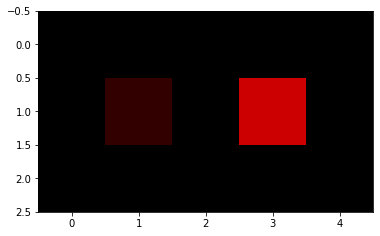

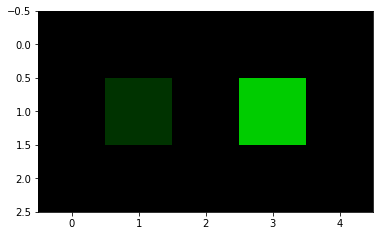

In [11]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

True ratio domain A: 0.5
Count: tensor([124, 132]) Ratio in this batch: tensor([0.4844, 0.5156])


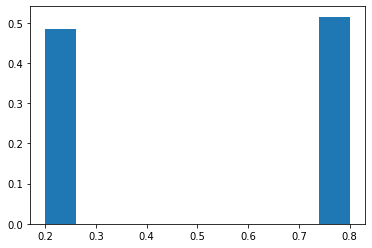

True ratio domain B: 0.5
Count: tensor([113, 143]) Ratio in this batch: tensor([0.4414, 0.5586])


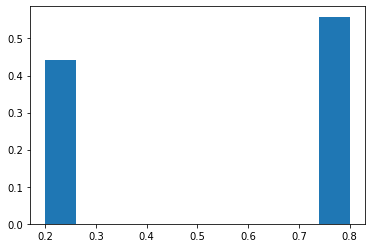

In [12]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

## The training loop

In [13]:
# Initialize the networks
weight_network_A = TrivialWeightNet()
weight_network_B = TrivialWeightNet()
generator_A = Generator()
generator_B = Generator()
discriminator = Discriminator()

# Initialize the optimizers
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=0.001)
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []


for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_w.zero_grad()
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # The weighting process
        w = weight_network_A(data_A).squeeze() # Get the importances for each image in domain A
        v = -weight_network_B(data_B).squeeze() # Get the importances for each image in domain B

        # Generated images
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)

        # The loss function --------------------------------------------------------------------------------
        
        # For storing purposes
        Lmin = (discriminator(torch.cat((real_A, fake_B))) * 0.5*(1 + w.detach())).sum().detach()
        Lplus = (discriminator(torch.cat((fake_A, real_B))) * 0.5*(1 + v.detach())).sum().detach()
        
        # The losses that are used for backprop
        loss_d = (discriminator(torch.cat((fake_A.detach(), real_B))) * 0.5*(1 + v.detach())).sum() - \
                 (discriminator(torch.cat((real_A, fake_B.detach()))) * 0.5*(1 + w.detach())).sum()
        
        loss_w = ((discriminator(torch.cat((real_A, fake_B.detach()))) * 0.5*(1 + w)).sum() - \
                  (discriminator(torch.cat((fake_A.detach(), real_B))) * 0.5*(1 + v)).sum())**2
        
        loss_g = (discriminator(torch.cat((real_A, fake_B))) * 0.5*(1 + w.detach())).sum() - \
                 (discriminator(torch.cat((fake_A, real_B))) * 0.5*(1 + v.detach())).sum()
        # ---------------------------------------------------------------------------------------------------

        # Backward
        loss_d.backward()
        loss_g.backward()
        loss_w.backward()

        # Optimization step
        optimizer_d.step()
        optimizer_g.step()
        optimizer_w.step()

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]

        w_a = weight_network_A(dataset_A.example_imgs)
        w_b = weight_network_B(dataset_B.example_imgs)
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g: ', loss_g.item(), 'loss_d: ', loss_d.item(), 'loss_w: ', loss_w.item())

step 0 loss_g:  69.4173583984375 loss_d:  -69.4173583984375 loss_w:  4818.76953125
step 500 loss_g:  29.07830810546875 loss_d:  -29.07830810546875 loss_w:  845.5479736328125
step 1000 loss_g:  17.56524658203125 loss_d:  -17.56524658203125 loss_w:  308.5378723144531
step 1500 loss_g:  29.4658203125 loss_d:  -29.4658203125 loss_w:  868.2345581054688
step 2000 loss_g:  27.753662109375 loss_d:  -27.753662109375 loss_w:  770.2657470703125
step 2500 loss_g:  -6.26171875 loss_d:  6.26171875 loss_w:  39.20912170410156
step 3000 loss_g:  -57.0283203125 loss_d:  57.0283203125 loss_w:  3252.229248046875
step 3500 loss_g:  -12.07666015625 loss_d:  12.07666015625 loss_w:  145.84571838378906
step 4000 loss_g:  22.8868408203125 loss_d:  -22.8868408203125 loss_w:  523.8074951171875
step 4500 loss_g:  -15.069580078125 loss_d:  15.069580078125 loss_w:  227.0922393798828
step 5000 loss_g:  -21.03662109375 loss_d:  21.03662109375 loss_w:  442.5394287109375
step 5500 loss_g:  -27.087158203125 loss_d:  27.0

### Interpretation

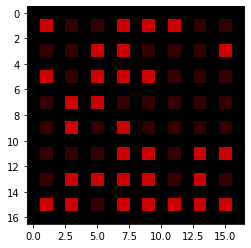

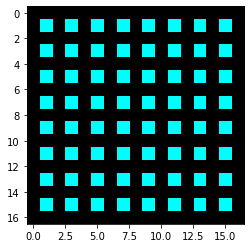

True ratio domain A 0.5


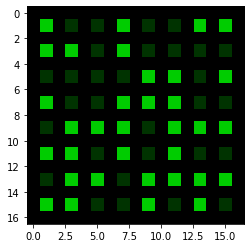

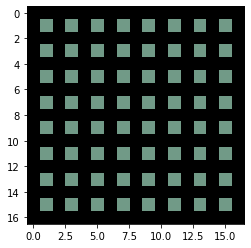

True ratio domain B 0.5


In [14]:
visualize_img_batch(real_A[:64])
visualize_img_batch(fake_B.detach()[:64])
print('True ratio domain A {}'.format(ratio_A))
# plot_hist(real_A)

visualize_img_batch(real_B[:64])
visualize_img_batch(fake_A.detach()[:64])
print('True ratio domain B {}'.format(ratio_B))
# plot_hist(real_B)

In [15]:
# # Some generated images
# visualize_img_batch(fake_A.detach())
# plot_hist(fake_A.detach())

# visualize_img_batch(fake_B.detach())
# plot_hist(fake_B.detach())

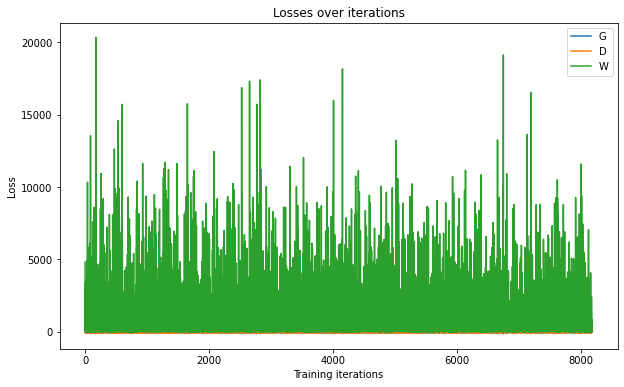

In [24]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_g)
plt.plot(losses_d)
plt.plot(losses_w)
plt.legend(['G', 'D', 'W'])
plt.show()

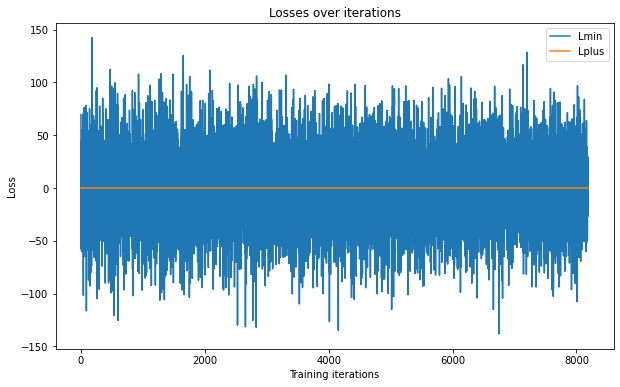

In [25]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

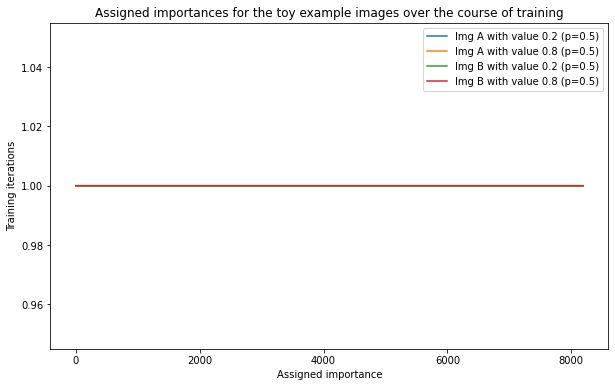

In [18]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()

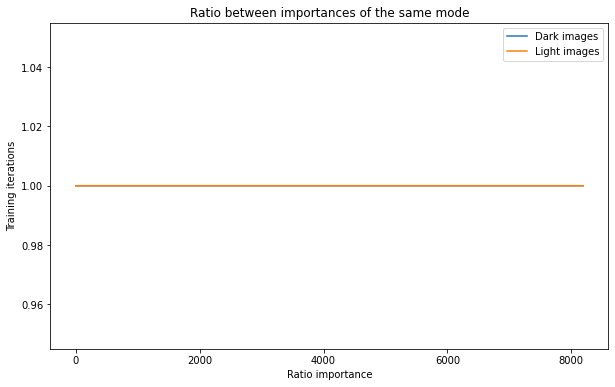

In [19]:
plt.figure(figsize=(10,6))
plt.title('Ratio between importances of the same mode')
plt.plot(torch.Tensor(example_importances_A)[:, 0]/torch.Tensor(example_importances_B)[:, 0])
plt.plot(torch.Tensor(example_importances_A)[:, 1]/torch.Tensor(example_importances_B)[:, 1])
plt.legend(['Dark images', 'Light images'])
plt.xlabel('Ratio importance')
plt.ylabel('Training iterations')
plt.show()

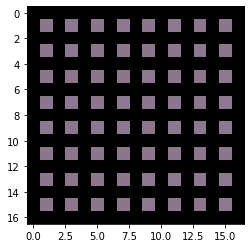

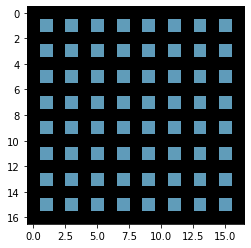

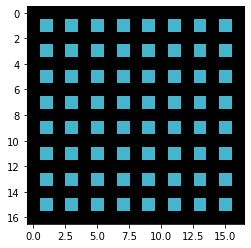

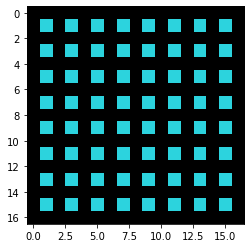

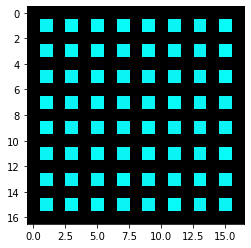

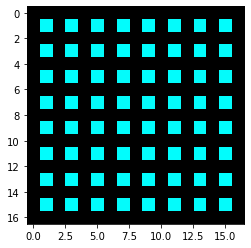

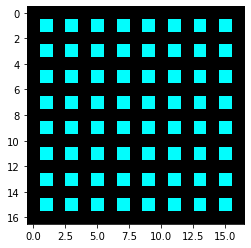

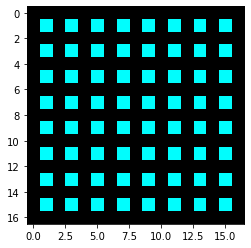

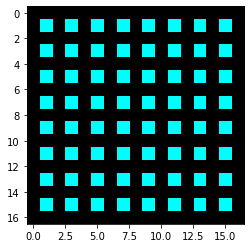

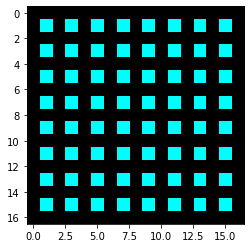

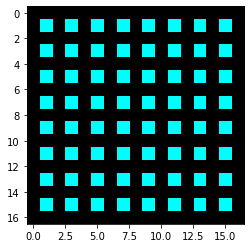

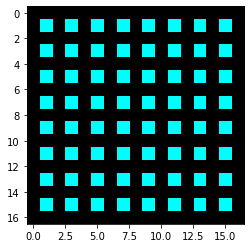

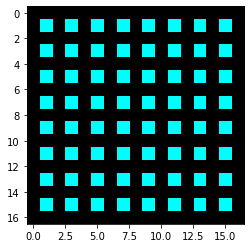

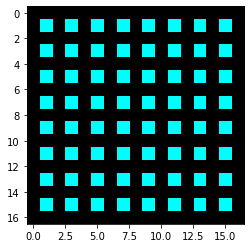

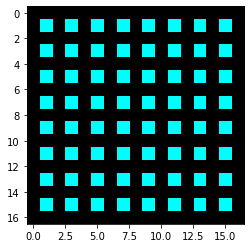

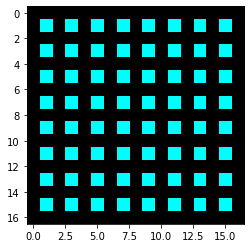

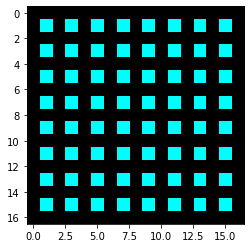

In [27]:
for img in samples_B:
    visualize_img_batch(img[:64])